# AirBnB : Part 1b : data preparation for reviews text.

In this part, we briefly analyze the content of the text reviews.

Then after having vectorized those reviews, we will use dimensionality reduction to make them usable as predictors.

At the end of the process, using the Principal Components Eigenvectors,  we build new features and add them to the listing dataset.

In [1]:
%matplotlib inline

import numpy as np
from ggplot import *
import pandas as pd
from langdetect import detect
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,HashingVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.decomposition import TruncatedSVD


from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix,classification_report

from xgboost import XGBRegressor

import nltk
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from utils import detect_lang,rstr

/home/ramon/anaconda2/lib/python2.7/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/ramon/anaconda2/lib/python2.7/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/home/ramon/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/home/ramon/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and fu

## Label the reviews per language

Before proceeding to text vectorization, we label each review with its corresponding language.

To implement this, i use the the [langdetect](https://pypi.python.org/pypi/langdetect?) package

In [2]:
def add_language_to_reviews(df):
    df_reviews = pd.read_csv('data/reviews.csv')
    df_reviews["comments2"] = df_reviews.comments.apply(lambda x:str(x).decode('utf-8'))
    df_reviews['language']= df_reviews.comments2.apply(detect_lang)
    df_reviews.to_csv("data/reviews_with_lang.csv")

In [3]:
df_reviews = pd.read_csv('data/reviews_with_lang.csv')

# drop missing reviews
df_reviews = df_reviews[~df_reviews.comments.isnull()]

# retrieve clean listing data from Data Preparation
df_listing = pd.read_csv('data/listing_cleansed.csv')


Once each reviews has been labelled, we can proceed to a short analysis regarding the relationships between the languages reviews and the appartment rating.

In [4]:
df_reviews  = pd.merge(df_reviews,df_listing[['id','review_scores_rating','review_scores_cleanliness','availability_30','availability_90','reviews_per_month','price']],left_on='listing_id',right_on='id' )

### Cancelled reservations

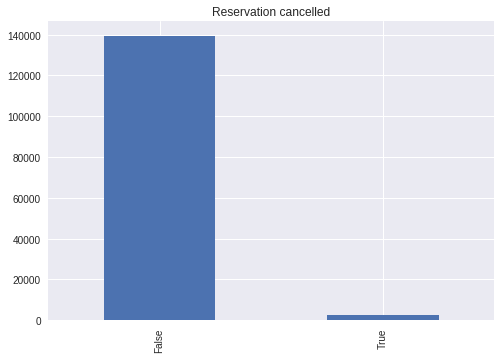

In [5]:
df_reviews.comments.str.contains('The host canceled this reservation').value_counts(dropna=False).plot.bar(title='Reservation cancelled')

### Drop cancelled reservations

In [6]:
df_reviews = df_reviews[~df_reviews.comments.str.contains('The host canceled this reservation')]

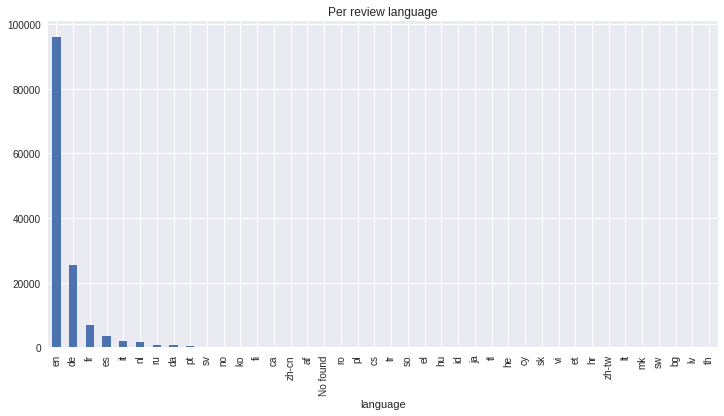

In [7]:
groupy_per_lang = df_reviews.groupby('language').comments.count().sort_values(ascending = False)

groupy_per_lang.plot.bar(title="Per review language",figsize=(12, 6))

In [8]:
df_lang = pd.DataFrame(groupy_per_lang)
df_lang['% total reviews']=np.round(df_lang.comments/df_lang.comments.sum()*100.0,2)
df_lang.head()

,comments,% total reviews
language,,
en,96099,68.86
de,25476,18.25
fr,7021,5.03
es,3664,2.63
it,1907,1.37


From this chart, we will only use reviews written in english (69% of the total reviews)

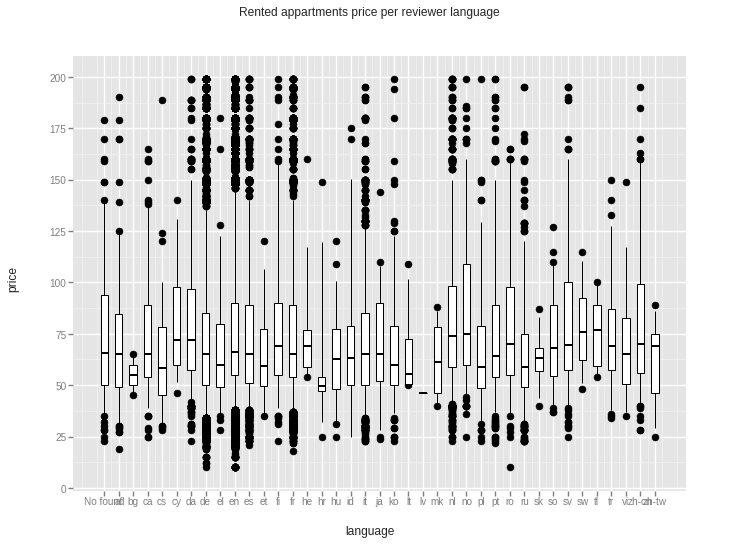

<ggplot: (8766047578213)>

In [9]:
ggplot(df_reviews[df_reviews.price<200],aes(x='language', y='price'))+geom_boxplot() +ggtitle('Rented appartments price per reviewer language')

Out of scope here, but still interesting, the high median price for scandinavian hosts, and low ones for countries from Balkans.

In [10]:
def concat_comments(x):
    x = x.str.replace(r'[^a-zA-Z\d\s:]','')
    return "%s" % '- '.join(x)

df_reviews_eng = df_reviews[df_reviews.language=='en']

df_reviews_eng = df_reviews_eng[~df_reviews_eng.review_scores_rating.isnull()]
df_reviews_eng = df_reviews_eng[~df_reviews_eng.comments.str.contains('The host canceled this reservation')]

In [11]:
df_reviews_grouped  = df_reviews_eng.groupby('listing_id').agg({'comments': concat_comments})

In [12]:
df_reviews_grouped = df_reviews_grouped.reset_index()
df_reviews_grouped

,listing_id,comments
0,1971,great location and out look over the spree flu...
1,2015,Jan was very friendly and welcoming host The a...
2,3176,excellent stay i would highly recommend it a n...
3,9991,The host was very welcoming and hospitable He ...
4,11203,He was a kind and polite gentleman\r\n\r\nThe ...
5,16644,a great apartment in a fantastic area\r\nwell ...
6,17904,It was a very calm cute and warm studio close ...
7,20858,Two friends and I stayed in this lovely apartm...
8,21869,Great room very comfortable and in good locati...
9,22415,we stayed 3 nights in Berlin The flat was nic...


In [13]:
df_listing_with_reviews = pd.merge(df_listing,df_reviews_grouped,left_on='id',right_on='listing_id',how='left')

In [14]:
print df_listing.shape
print df_listing_with_reviews.shape


(9208, 218)
(9208, 220)


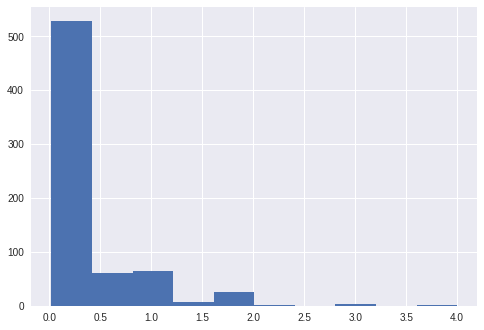

In [15]:
df_listing_with_reviews[df_listing_with_reviews.comments.isnull()].reviews_per_month.hist()

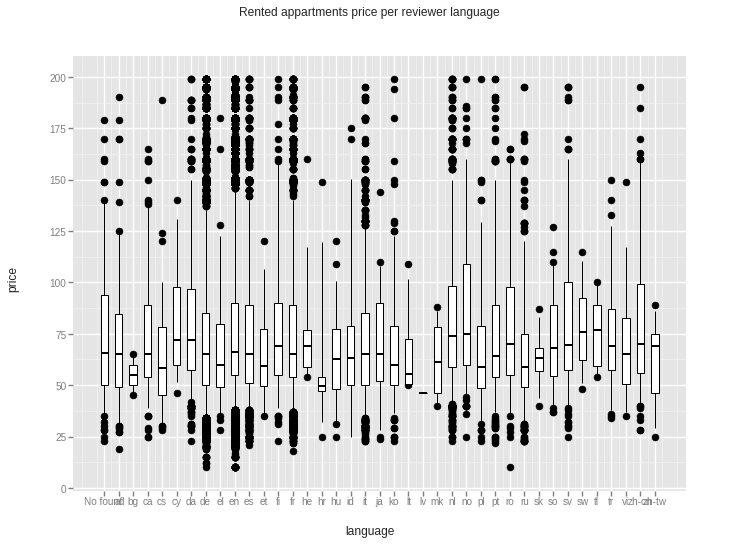

<ggplot: (8766045295829)>

In [16]:
ggplot(df_reviews[df_reviews.price<200],aes(x='language', y='price'))+geom_boxplot() +ggtitle('Rented appartments price per reviewer language')

In [17]:
df_listing_with_reviews.comments = df_listing_with_reviews.comments.str.lower()
df_listing_with_reviews.comments = df_listing_with_reviews.comments.fillna("no comment")

df_listing_with_reviews.comments = df_listing_with_reviews.comments.astype(str)

In [18]:
df_listing_with_reviews.comments

0                                              no comment
1       super nice newly renovated place loved the was...
2       the bed and garden was very nice me and my hus...
3       amazing place excellent location and amazing h...
4                                              no comment
5       such a beautiful apartment and community to st...
6                                              no comment
7                                              no comment
8       very cosy flat at first i thought it might be ...
9                                              no comment
10                                             no comment
11      its not in the city center but with the u and ...
12                                             no comment
13      the place is small but somehow cozy and is par...
14      as everything was more than perfect my review ...
15                                             no comment
16                                             no comment
17      my wif

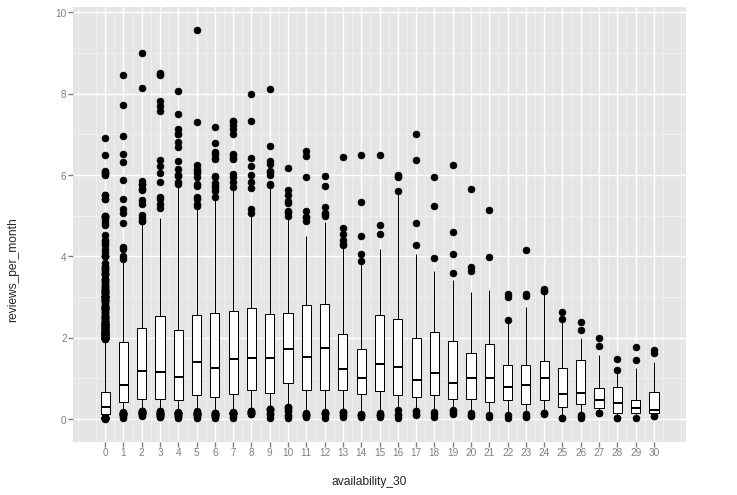

<ggplot: (8766046839033)>

In [19]:
ggplot(df_listing_with_reviews,aes(x='availability_30',y='reviews_per_month'))+geom_boxplot()

Critical informations here : The appartments with Zero availability are mostly appartments that are not rented (very low number of reviews per months) rather than fully booked. We can exclude them.

In [20]:
df_listing_with_reviews[['review_scores_rating','availability_90','availability_30']].describe()

,review_scores_rating,availability_90,availability_30
count,7600.000000,9208.000000,9208.000000
mean,93.277763,17.376520,4.290400
std,7.854820,25.105169,7.091632
min,20.000000,0.000000,0.000000
25%,90.000000,0.000000,0.000000
50%,95.000000,3.000000,0.000000
75%,100.000000,27.000000,6.000000
max,100.000000,90.000000,30.000000


### Remove stop words, host names and Stem text reviews.

#### Host names

In [21]:
all_host_names = df_listing.host_name.str.lower()
all_host_names = all_host_names.unique().tolist()

In [22]:
len(all_host_names)

3213

#### Stop words and stem

In [23]:
porter = nltk.stem.porter.PorterStemmer()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

stop = nltk.corpus.stopwords.words('english')
stop =list(set(stop)-set(['no', 'not', 'never','don\'t','couldn\'t']))+all_host_names

### Implement a simple binary categories : good / bad appartment according to the review score rating

In [24]:
df_listing_with_reviews['good_bad_review']=np.where(df_listing_with_reviews.review_scores_rating>94,'good','bad')
X = df_listing_with_reviews.comments.values
y = df_listing_with_reviews.good_bad_review.values

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

### Vectorize text using Tfidf

In [25]:
vectorizer = TfidfVectorizer(ngram_range=(2,3),tokenizer=tokenizer_porter,stop_words=stop,max_features=20000)
X_train_vectorized = vectorizer.fit_transform(X_train).todense()

### Scale data for PCA

In [26]:
scaler = MinMaxScaler()
X_train_vectorized = scaler.fit_transform(X_train_vectorized)

In [27]:
X_test_vectorized = vectorizer.transform(X_test).todense()
X_test_vectorized = scaler.transform(X_test_vectorized)

### Quick classification overview

In order the check wether using the reviews as predictor, we can run a simple classification tasks on whether the review score is higher than the median value (94%, which balances the dataset):

In [28]:
clf = MultinomialNB()
clf.fit(X_train_vectorized,y_train)
predicted = clf.predict(X_test_vectorized)

In [29]:
print confusion_matrix(y_test,predicted)
print classification_report(predicted,y_test)

[[852 187]
 [300 503]]
             precision    recall  f1-score   support

        bad       0.82      0.74      0.78      1152
       good       0.63      0.73      0.67       690

avg / total       0.75      0.74      0.74      1842



Even if not very accurate, using those features could be good additional predictor for our regressor.

In [30]:
idf = vectorizer.idf_
df_idf = pd.DataFrame.from_dict(dict(zip(vectorizer.get_feature_names(), idf)),orient='index')
df_idf.columns=['TFIDF']
df_idf = df_idf.sort_values(by='TFIDF',ascending=False)
df_idf.head()

,TFIDF
lanc wa,9.211619
vinni wa,9.211619
imm wa,9.211619
- vinni,9.211619
stay vinni,9.211619


Interesting enough, we can check which stemmed word are weighting the most in this binary classification :

In [31]:
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print "\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2)
        
show_most_informative_features(vectorizer,clf,n=40)

	-12.1772	- vinni        		-6.1418	apart wa       
	-12.1772	etienn wa      		-6.2644	everyth need   
	-12.1772	jena wa        		-6.5032	would definit  
	-12.1772	marylis wa     		-6.5137	no comment     
	-12.1772	mauric wa      		-6.5199	wa veri        
	-12.1772	nestor wa      		-6.5203	recommend thi  
	-12.1772	no toilet      		-6.6167	public transport
	-12.1772	no toilet paper		-6.7756	veri help      
	-12.1772	silk wa        		-6.8919	great locat    
	-12.1772	stay vinni     		-6.8923	gave us        
	-12.1772	veri dirti     		-6.8957	veri close     
	-12.1772	viliu wa       		-6.9026	highli recommend
	-12.1772	vinni place    		-6.9311	veri clean     
	-12.1772	vinni wa       		-6.9327	walk distanc   
	-12.1215	mattress floor 		-6.9412	thi apart      
	-12.1016	bit disappoint 		-6.9584	berlin -       
	-12.0750	ran wa         		-6.9692	wa great       
	-12.0278	veri bad       		-6.9970	come back      
	-12.0275	not veri clean 		-6.9992	apart veri     
	-12.0166	mathia wa      		-7

Well, toilet papers, bad internet, broken shower head seem to be a no-go.

### Dimensionality reduction


Now we have scaled vectorized vector using Tfidf, we can reduce the number of columns using a PCA

In [32]:
n_components=300
svd = TruncatedSVD(n_components=n_components)
X_train_svd = svd.fit_transform(X_train_vectorized)
X_test_svd = svd.transform(X_test_vectorized)

In [33]:
print "Explained variance with {0} components : {1}".format(n_components,svd.explained_variance_ratio_.sum()*100)

Explained variance with 300 components : 21.6576404597


## Add PCA of reviews to dataset :

Finally, we can vectorize the full set with Tfidf, scale it, and use PCA to summarize with only 300 vectors :

In [34]:
X_all_reviews = vectorizer.fit_transform(X).todense()
X_all_reviews_TFIDF_scaled =scaler.fit_transform(X_all_reviews)

In [35]:
print X.shape
print X_all_reviews.shape
print X_all_reviews_TFIDF_scaled.shape

(9208,)
(9208, 20000)
(9208, 20000)


In [36]:
X_all_reviews_PCA = svd.fit_transform(X_all_reviews_TFIDF_scaled,n_components=300)
print svd.explained_variance_ratio_.sum()*100

TypeError: fit_transform() got an unexpected keyword argument 'n_components'

Via a PCA, we dropped the reviews matrix from 20000 columns to 300.
We can now append it to the listing dataset :

In [ ]:
df_reviews_PCA = pd.DataFrame(X_all_reviews_PCA)
df_reviews_PCA.columns = ['reviews_PC_'+str(i) for i in range(1,n_components+1) ]

In [ ]:
df_reviews_PCA.shape

In [ ]:
df_listing_with_reviews = pd.concat([df_listing_with_reviews,df_reviews_PCA],axis=1)

In [ ]:
df_listing_with_reviews.to_csv('data/df_listing_with_reviewsPCA.csv',index=False)